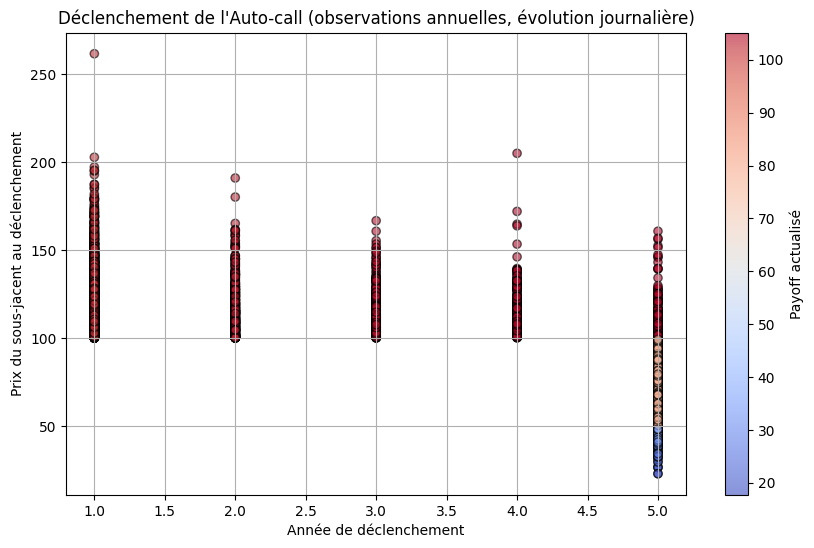

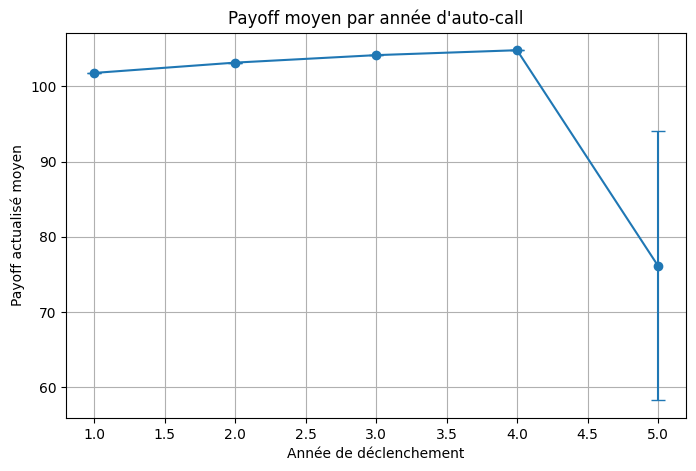

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def simulate_autocall_athena_daily(S0=100, trigger=100, barrier=50, coupon=0.07, T=5, r=0.05, sigma=0.20, trading_days_per_year=252, n_sim=5000, seed=42):
    """
    Simule n_sim trajectoires d’un produit autocall de type Athéna sur T années en simulant l’évolution journalière.

    Paramètres :
      S0                  : Prix initial du sous-jacent (par exemple, 100)
      trigger             : Niveau de rappel (auto-call) (ex. 100)
      barrier             : Barrière de protection à maturité (ex. 50)
      coupon              : Coupon annuel (ex. 0.07 pour 7%)
      T                   : Maturité en années (ex. 5)
      r                   : Taux sans risque (ex. 0.05)
      sigma               : Volatilité (ex. 0.20)
      trading_days_per_year: Nombre de jours de trading par an (ex. 252)
      n_sim               : Nombre de simulations
      seed                : Graine pour la reproductibilité

    Retourne :
      trigger_years : Tableau des années d’auto-call (ou T si non déclenché)
      trigger_prices: Tableau des prix du sous-jacent au moment du déclenchement
      payoffs       : Tableau des payoffs actualisés correspondants
    """
    np.random.seed(seed)
    total_days = int(T * trading_days_per_year)  # nombre total de jours sur T années
    dt = T / total_days  # pas de temps en années
    # Indices de vérification annuels (par ex. à la fin de chaque année)
    observation_days = np.array([trading_days_per_year * (i+1) for i in range(T)])

    trigger_years = []
    trigger_prices = []
    payoffs = []

    for i in range(n_sim):
        S = S0
        triggered = False
        # Simuler l'évolution quotidienne
        for day in range(1, total_days + 1):
            # Mise à jour du sous-jacent selon GBM sous mesure risque-neutre
            S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn())
            # Si c'est un jour d'observation, vérifier le déclenchement
            if day in observation_days:
                # Convertir le jour en années (ex : 252 jours = 1 an)
                t_year = day / trading_days_per_year
                if S >= trigger:
                    # Auto-call déclenché : calcul du payoff avec coupon accumulé
                    payoff = 100 * (1 + coupon * t_year)
                    payoff_discounted = payoff * np.exp(-r * t_year)
                    trigger_years.append(t_year)
                    trigger_prices.append(S)
                    payoffs.append(payoff_discounted)
                    triggered = True
                    break
        if not triggered:
            # Aucun auto-call sur toute la période, à maturité T
            t_year = T
            if S >= barrier:
                payoff = 100
            else:
                payoff = S  # cas de perte proportionnelle
            payoff_discounted = payoff * np.exp(-r * T)
            trigger_years.append(T)
            trigger_prices.append(S)
            payoffs.append(payoff_discounted)

    return np.array(trigger_years), np.array(trigger_prices), np.array(payoffs)

# Simulation
trigger_years, trigger_prices, payoffs = simulate_autocall_athena_daily()

# Premier graphique : scatter plot
plt.figure(figsize=(10,6))
sc = plt.scatter(trigger_years, trigger_prices, c=payoffs, cmap='coolwarm', alpha=0.6, edgecolor='k')
plt.colorbar(sc, label='Payoff actualisé')
plt.xlabel('Année de déclenchement')
plt.ylabel('Prix du sous-jacent au déclenchement')
plt.title("Déclenchement de l'Auto-call (observations annuelles, évolution journalière)")
plt.grid(True)
plt.show()

# Deuxième graphique : moyenne des payoffs par année de déclenchement
unique_years = np.unique(trigger_years)
mean_payoffs = [np.mean(payoffs[trigger_years == year]) for year in unique_years]
std_payoffs = [np.std(payoffs[trigger_years == year]) for year in unique_years]

plt.figure(figsize=(8,5))
plt.errorbar(unique_years, mean_payoffs, yerr=std_payoffs, fmt='-o', capsize=5)
plt.xlabel("Année de déclenchement")
plt.ylabel("Payoff actualisé moyen")
plt.title("Payoff moyen par année d'auto-call")
plt.grid(True)
plt.show()




In [ ]:
import numpy as np

# Paramètres de la simulation
S0 = 100  # Prix initial
trigger = 150  # Niveau de déclenchement de l'auto-call
barrier = 50  # Barrière de protection à maturité
coupon = 0.07  # Coupon annuel
T = 5  # Maturité en années
r = 0.05  # Taux sans risque
sigma = 0.20  # Volatilité
trading_days_per_year = 252  # Nombre de jours de trading par an
n_sim = 10000  # Nombre de simulations
seed = 42  # Graine pour la reproductibilité

np.random.seed(seed)
dt = 1 / trading_days_per_year  # Pas de temps en années
total_days = int(T * trading_days_per_year)  # Nombre total de jours
observation_days = [int(trading_days_per_year * (i + 1)) for i in range(T)]  # Jours d'observation annuels

payoffs = []

for _ in range(n_sim):
    S = S0
    for day in range(1, total_days + 1):
        # Simulation de l'évolution du sous-jacent
        Z = np.random.normal()
        S *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

        # Vérification aux dates d'observation
        if day in observation_days:
            t = day / trading_days_per_year
            if S >= trigger:
                payoff = 100 * (1 + coupon * t)
                payoff_discounted = payoff * np.exp(-r * t)
                payoffs.append(payoff_discounted)
                break
    else:
        # À maturité
        if S >= barrier:
            payoff = 100
        else:
            payoff = S
        payoff_discounted = payoff * np.exp(-r * T)
        payoffs.append(payoff_discounted)

# Calcul du prix estimé du produit
price_estimate = np.mean(payoffs)
print(f"Prix estimé du produit structuré : {price_estimate:.2f}")


Prix estimé du produit structuré : 85.95


In [ ]:
import numpy as np

def price_autocall_athena_mc(S0=100, trigger=150, barrier=50, coupon=0.07, T=5, r=0.05, sigma=0.20, n_sim=1000000, seed=42):
    """
    Prix d'un autocall de type Athéna par simulation Monte Carlo.

    Paramètres :
      S0      : valeur initiale du sous-jacent
      trigger : niveau de rappel (auto-call) (ex. 100)
      barrier : barrière de protection du capital à maturité (ex. 50)
      coupon  : coupon annuel (ex. 0.07)
      T       : maturité en années
      r       : taux sans risque
      sigma   : volatilité du sous-jacent
      n_sim   : nombre de simulations Monte Carlo
      seed    : graine pour la reproductibilité

    Méthode :
      On simule des trajectoires en temps discret (annuel ici).
      À chaque date d'observation (t=1,..,T) :
         - Si S_t >= trigger, le produit est rappelé et le payoff est
           100*(1 + t*coupon), actualisé à l'instant 0.
         - Sinon, on continue la simulation.
      À maturité, si aucun rappel n'est survenu :
         - Si S_T >= barrier, l'investisseur récupère 100.
         - Sinon, le payoff est proportionnel (S_T).
      Le prix est la moyenne des payoffs actualisés.
    """
    np.random.seed(seed)
    dt = 1.0  # fréquence annuelle
    payoffs = np.zeros(n_sim)

    for i in range(n_sim):
        S = S0
        auto_called = False
        # Simulation pour chaque année t=1,...,T
        for t in range(1, T+1):
            # Évolution selon la GBM sous mesure risque-neutre
            S = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn())
            if S >= trigger:
                # Auto-call déclenché : coupon accumulé = t * coupon
                coupon_accum = t * coupon
                payoff = 100 * (1 + coupon_accum)
                # Actualisation à l'instant 0
                payoff_discounted = payoff * np.exp(-r * t)
                payoffs[i] = payoff_discounted
                auto_called = True
                break
        if not auto_called:
            # Aucun auto-call jusqu'à maturité
            if S >= barrier:
                payoff = 100
            else:
                payoff = S  # perte proportionnelle
            payoff_discounted = payoff * np.exp(-r * T)
            payoffs[i] = payoff_discounted
    return np.mean(payoffs)

# Calcul du prix par Monte Carlo
price_mc = price_autocall_athena_mc()
print("Prix Monte Carlo (Athéna):", price_mc)


Prix Monte Carlo (Athéna): 86.0771741294702


Ci-dessous deux implémentations Python permettant de « pricer » un autocall de type Athéna, à l’aide de deux méthodes différentes :

1. Une simulation Monte Carlo  
2. Un modèle par arbre binomial (backward induction)

Pour rappel, nous considérons un produit structuré avec les caractéristiques suivantes (exemple simplifié) :

- Sous-jacent initial : $ S_0 = 100 $  
- Date d'observation annuelle, pour $ T=5 $ ans  
- **Autocall Trigger** (barrière de rappel) : $ S_t \ge 100 $  
- **Coupon annuel** : $ c=7\% $. Dans un produit Athéna, les coupons sont accumulés et ne sont payés qu'au déclenchement de l'auto-call ou à maturité. Ainsi, si le rappel survient à la date $ t $ (en années), le paiement immédiat sera
  $$
  \text{Payoff} = 100\,(1 + t\cdot c)
  $$
- À maturité, si aucun rappel n’est survenu, on suppose :
  - Si $ S_T \ge \text{barrière de protection} $ (par exemple $50$), l'investisseur récupère 100.
  - Sinon, il subit une perte proportionnelle : $ \text{Payoff} = 100 \times \frac{S_T}{100} = S_T $.
Pour le pricing, nous utilisons la mesure risque-neutre $r$, avec :
- $ r = 5\% $ par an  
- $ \sigma = 20\% $ par an

---

## Méthode 1 : Simulation Monte Carlo

Dans cette méthode, nous simulons $N$ trajectoires du sous-jacent en utilisant la dynamique du mouvement brownien géométrique sous la mesure risque-neutre :
$$
S_{t+dt} = S_t \exp\Bigl(\Bigl(r-\tfrac{1}{2}\sigma^2\Bigr)dt + \sigma\sqrt{dt}\, Z\Bigr)
$$
avec $Z \sim \mathcal{N}(0,1)$.

À chaque date d'observation $t=1,\dots,T$, on vérifie si $S_t \ge 100$. Dans ce cas, le produit est automatiquement rappelé et le payoff est calculé avec la somme des coupons accumulés jusqu'à ce $t$. Sinon, la trajectoire continue. À maturité, le payoff est déterminé selon que $S_T$ soit au-dessus ou en dessous de la barrière de protection.


### Explications en LaTeX

Le modèle utilisé repose sur la dynamique :
$$
S_{t+1} = S_t \exp\left(\left(r-\frac{1}{2}\sigma^2\right)dt + \sigma\sqrt{dt}\,Z_t\right),\quad Z_t\sim\mathcal{N}(0,1),
$$
avec $dt=1$ an. À chaque observation t, on teste :
$$
\text{Si } S_t \geq \text{trigger},\quad \text{payoff} = 100 \times \left(1 + t\cdot \text{coupon}\right).
$$
Le payoff est actualisé par $e^{-r t}$. Sinon, à maturité $t=T$, on a :
$$
\text{Payoff} =
\begin{cases}
100, & \text{si } S_T \geq \text{barrier},\\[1mm]
100\cdot \frac{S_T}{100} = S_T, & \text{si } S_T < \text{barrier}.
\end{cases}
$$
Le prix du produit est estimé par la moyenne des payoffs actualisés sur l'ensemble des simulations.



## Méthode 2 : Modèle par Arbre Binomial

Nous construisons un arbre binomial discret sur \(N=5\) périodes (annuelles). Pour chaque nœud à l'étape $i$ et avec $j$ montées, le prix du sous-jacent est :
$$
S_{i,j} = S_0 \, u^{\,j} d^{\,i-j},
$$
où $u = e^{\sigma \sqrt{dt}}$, $d = e^{-\sigma \sqrt{dt}}$ et la probabilité risque-neutre est :
$$
p = \frac{e^{r\, dt} - d}{u - d}.
$$
À chaque date d'observation (chaque étape), si $S_{i,j} \ge \text{trigger}$, le produit est rappelé avec payoff :
$$
\text{Payoff}_{\text{call}} = 100\,(1 + i\cdot \text{coupon}).
$$
Sinon, la valeur du produit est donnée par la valeur espérée actualisée des nœuds suivants. À maturité $i=N$, le payoff est :
$$
\text{Payoff} =
\begin{cases}
100, & \text{si } S_{N,j} \ge \text{barrier},\\[1mm]
S_{N,j}, & \text{si } S_{N,j} < \text{barrier}.
\end{cases}
$$




Dans l'arbre binomial, à chaque nœud $(i,j)$, le prix est :
$$
S_{i,j} = S_0 \, u^{\,j} \, d^{\,i-j},\quad u = e^{\sigma\sqrt{dt}},\quad d = \frac{1}{u},
$$
avec probabilité risque‑neutre
$$
p = \frac{e^{r\, dt}-d}{u-d}.
$$
À un nœud d'observation, si $S_{i,j}\geq \text{trigger}$, le payoff immédiat est :
$$
V_{i,j} = 100\,(1+i\cdot \text{coupon}).
$$
Sinon, la valeur est donnée par la moyenne actualisée des valeurs des nœuds suivants :
$$
V_{i,j} = e^{-r\, dt}\Bigl(p\,V_{i+1,j+1}+(1-p)\,V_{i+1,j}\Bigr).
$$
À maturité $i=N$, on a :
$$
V_{N,j} =
\begin{cases}
100,& \text{si } S_{N,j}\geq \text{barrier},\\[1mm]
S_{N,j},& \text{sinon}.
\end{cases}
$$
Le prix de l'autocall est alors $V_{0,0}$.

---

## Conclusion

Nous avons présenté deux méthodes pour pricer un autocall de type Athéna :

- **Méthode Monte Carlo** : qui simule de nombreuses trajectoires du sous‑jacent et applique les règles du produit aux dates d’observation.
- **Méthode par Arbre Binomial** : qui effectue une induction rétrograde en tenant compte de la condition d’auto‑call à chaque nœud.

Chaque méthode repose sur les principes du pricing sous mesure risque‑neutre et permet, par calibration des paramètres (volatilité, taux sans risque), d’obtenir une estimation du prix du produit structuré.

Ces codes illustrent une version simplifiée du produit ; en pratique, les produits structurés réels peuvent intégrer des caractéristiques supplémentaires (effet mémoire, multiples sous‑jacents, ajustements de barrières, etc.) nécessitant des modèles plus sophistiqués.

In [ ]:
def price_autocall_athena_tree(S0=100, trigger=150, barrier=50, coupon=0.07, T=5, r=0.05, sigma=0.20, dt=1.0):
    """
    Prix d'un autocall de type Athéna par un arbre binomial à observation annuelle.

    Paramètres :
      S0      : valeur initiale du sous-jacent
      trigger : barrière de rappel (ex. 100)
      barrier : barrière de protection du capital à maturité (ex. 50)
      coupon  : coupon annuel (ex. 0.07)
      T       : maturité en années
      r       : taux sans risque
      sigma   : volatilité
      dt      : pas de temps (1 an)

    Méthode :
      Construction d'un arbre recombining binomial sur N = T/dt périodes.
      À chaque nœud (i, j) (i=temps, j=nombre de montées), le prix du sous-jacent est :
          S = S0 * u^j * d^(i-j)
      Si à une date d'observation (i > 0), S >= trigger, le produit est rappelé et
      la valeur est 100*(1 + i*coupon).
      Sinon, on calcule la valeur de continuation par actualisation.
      À maturité (i = N), le payoff est :
          100 si S >= barrier, sinon S (perte proportionnelle).
    """
    N = int(T / dt)
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Dictionnaires pour stocker les prix et valeurs aux nœuds : (i, j)
    prices = {}
    values = {}

    # Terminal nodes (maturité T = N)
    for j in range(N + 1):
        S = S0 * (u ** j) * (d ** (N - j))
        prices[(N, j)] = S
        if S >= barrier:
            payoff = 100
        else:
            payoff = S  # ici S est déjà proportionnel puisque S0=100
        values[(N, j)] = payoff

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            S = S0 * (u ** j) * (d ** (i - j))
            prices[(i, j)] = S
            # Si la condition d'auto-call est satisfaite à cette observation, on fixe la valeur immédiate.
            if S >= trigger:
                immediate_value = 100 * (1 + i * coupon)
                values[(i, j)] = immediate_value
            else:
                # Valeur de continuation
                value_up = values[(i + 1, j + 1)]
                value_down = values[(i + 1, j)]
                cont_value = np.exp(-r * dt) * (p * value_up + (1 - p) * value_down)
                values[(i, j)] = cont_value
    return values[(0, 0)]

# Calcul du prix par l'arbre binomial
price_tree = price_autocall_athena_tree()
print("Prix par arbre binomial (Athéna):", price_tree)



Prix par arbre binomial (Athéna): 82.27582903022288
